In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# For model building
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestRegressor

## This notebook will be used for building a random forest in python.

Loading in the data to be used

In [2]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data

temp = []
for x in [2010 + x for x in range(8)] :
#   add dtype declaration to remove warning
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
                   # dtype = {"Start station ID" : pd.int64, "End station ID" : pd.int64, "Account type": pd.Categorical}
    temp.append(x)
    nr = pd.concat(temp)

/home/grimoire/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Changing dates from objects into datetimes
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start date'] = nr['Start date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))
nr['End date'] = nr['End date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))

Correcting missing data in the weather dataframe

In [4]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

### Preparing the data to be used for the model

In [5]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start date', 'Total duration (seconds)']].resample('D', on='Start date').count()
daily_totals = daily_totals.drop('Start date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"Total duration (seconds)": "DCOUNT",'Start date':'DATE'})

In [6]:
print(daily_totals.head())
print(daily_totals.describe())

        DATE  DCOUNT
0 2010-06-07       1
1 2010-06-08       2
2 2010-06-09       7
3 2010-06-10     104
4 2010-06-11     287
            DCOUNT
count  2709.000000
mean    994.531931
std    1058.519993
min       0.000000
25%       0.000000
50%     722.000000
75%    1732.000000
max    5625.000000


The daily totals DataFrame looks good

In [7]:
print(weather.keys())
# The weather station and name won't be necessary or add anything to our analysis
weather = weather.drop(['STATION', 'NAME'], axis=1)

Index(['STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN'],
      dtype='object')


In [8]:
weather.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9


In [9]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 9 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
SNOW      2922 non-null float64
SNWD      2922 non-null int64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
DCOUNT    2709 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 228.3 KB


,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,NaN
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,NaN
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,NaN
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,NaN
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,NaN


In [10]:
# Notice how the count of DCOUNT varies from what the other columns have
features = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 9 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
SNOW      2922 non-null float64
SNWD      2922 non-null int64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
DCOUNT    2922 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 228.3 KB


In [11]:
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0


This next section will change our date column from dtype datetime into seperate numerical relevant date colummns

In [12]:
features['YEAR'] = features['DATE'].dt.year
features['MONTH'] = features['DATE'].dt.month
features['DAY'] = features['DATE'].dt.day

In [13]:
features.head() # Three new, seperate, columns that identify year, month, day

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT,YEAR,MONTH,DAY
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,2010,1,1
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,2010,1,2
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,2010,1,3
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,2010,1,4
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,2010,1,5


In [14]:
# Create a weekday variable column Mon = 0, Sun = 6
features['WEND'] = features['DATE'].dt.weekday

In [15]:
# Adjust WEND column to be catagorical; If it's a weekday WEND = 0 else if weekend WEND = 1
features['WEND'] = features['WEND'].apply(lambda x:1 if x>4 else 0)
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT,YEAR,MONTH,DAY,WEND
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,2010,1,1,0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,2010,1,2,1
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,2010,1,3,1
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,2010,1,4,0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,2010,1,5,0


In [16]:
# Random forests can't use datetime objects
features = features.drop('DATE', axis=1)

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 12 columns):
AWND      2922 non-null float64
PRCP      2922 non-null float64
SNOW      2922 non-null float64
SNWD      2922 non-null int64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
DCOUNT    2922 non-null float64
YEAR      2922 non-null int64
MONTH     2922 non-null int64
DAY       2922 non-null int64
WEND      2922 non-null int64
dtypes: float64(5), int64(7)
memory usage: 296.8 KB


In [18]:
# Seperating our data sets
winter_features = features[features['DCOUNT'] == 0].reset_index(drop=True)

# Need to drop all days where there where no rides taken (Dcount = 0)
features = features[features['DCOUNT'] != 0].reset_index(drop=True)

In [19]:
features.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT,YEAR,MONTH,DAY,WEND
count,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000
mean,8.857259,0.126023,0.015357,0.064787,63.063287,72.171566,53.988002,1616.188962,2013.628674,7.191962,15.769646,0.285543
std,3.451232,0.344777,0.224634,0.582355,13.021535,13.991099,12.666982,903.294550,2.230847,2.051933,8.854145,0.451808
min,0.890000,0.000000,0.000000,0.000000,8.000000,19.000000,-3.000000,1.000000,2010.000000,1.000000,1.000000,0.000000
25%,6.490000,0.000000,0.000000,0.000000,54.000000,63.000000,45.000000,883.000000,2012.000000,6.000000,8.000000,0.000000
50%,8.500000,0.000000,0.000000,0.000000,66.000000,75.000000,56.000000,1501.000000,2014.000000,7.000000,16.000000,0.000000
75%,10.960000,0.050000,0.000000,0.000000,73.000000,83.000000,64.000000,2291.500000,2016.000000,9.000000,23.000000,1.000000
max,23.710000,4.130000,6.400000,8.000000,91.000000,103.000000,81.000000,5625.000000,2017.000000,11.000000,31.000000,1.000000


DCOUNT shows Minimum of at least 1, and the

I'm concerned why month shows min 1; there shouldn't be any data for January still. Time to investigate further

In [20]:
features[features.MONTH == 1]

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT,YEAR,MONTH,DAY,WEND
585,7.61,0.00,0.0,3,25.5,35,16,1.0,2013,1,8,0
586,10.29,0.28,0.0,2,31.5,39,24,1.0,2013,1,10,0


In [21]:
type(features.MONTH)

pandas.core.series.Series

Data looks good!

### Features, Targets, and converting Data in Arrays (optimizes performance)

In [22]:
# Saving the target/label variable and removing from features Dataframe
target = features.DCOUNT.values
feat = features.drop('DCOUNT', axis=1).values

# Saving the feature names for future use
feature_names = list(features.drop('DCOUNT', axis=1).columns)

In [23]:
# Splitting the data into training and test sets
X, X_test, y, y_test = train_test_split(feat, target, test_size=.25, random_state=42)

Inspecting the shape of the features and labels

In [24]:
print('Training Features shape', X.shape)
print('Training labels shape', y.shape)

print('Testing Features shape', X_test.shape)
print('Testing labels shape', y_test.shape)

Training Features shape (1250, 11)
Training labels shape (1250,)
Testing Features shape (417, 11)
Testing labels shape (417,)


## Establishing a baseline

Need to find what a good baseline would be

In [25]:
'''
Insert baseline creation code here
'''

'\nInsert baseline creation code here\n'

## Training the data

In [26]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Making predictions on the test set

In [27]:
predictions = rf.predict(X_test)

## Assessing the performance of our RandomForestRegressor

This is the r2 score

In [28]:
cv_r2 = cross_val_score(rf, X, y, cv=10)
print(cv_r2)
print(np.mean(cv_r2))

[0.84180783 0.89845457 0.85222656 0.84319775 0.86059427 0.85160301
 0.85752537 0.87682129 0.87803203 0.85475331]
0.8615015983758993


In [29]:
cv_negMSElog_error = cross_val_score(rf, X, y, scoring='neg_mean_squared_log_error', cv=5)
print(cv_negMSElog_error)
print(np.mean(cv_negMSElog_error))

[-0.16885009 -0.24482319 -0.20055172 -0.26516326 -0.16482204]
-0.20884206104326566


In [30]:
errors = abs(predictions - y_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  249.04


In [31]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  65.06 %


In [32]:
(errors == y_test).mean()

0.0

In [33]:
# Mean Absolute Square

In [34]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TMAX                 Importance: 0.39
Variable: YEAR                 Importance: 0.37
Variable: PRCP                 Importance: 0.07
Variable: MONTH                Importance: 0.04
Variable: WEND                 Importance: 0.04
Variable: AWND                 Importance: 0.03
Variable: DAY                  Importance: 0.03
Variable: TAVG                 Importance: 0.02
Variable: TMIN                 Importance: 0.02
Variable: SNOW                 Importance: 0.0
Variable: SNWD                 Importance: 0.0


## Visualizing the features and predictions

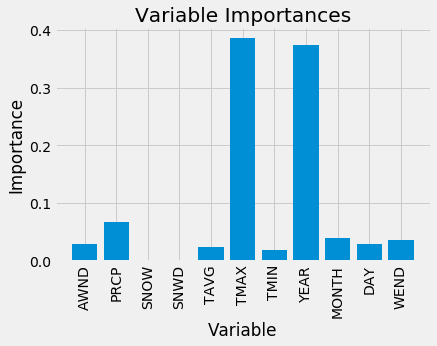

In [35]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

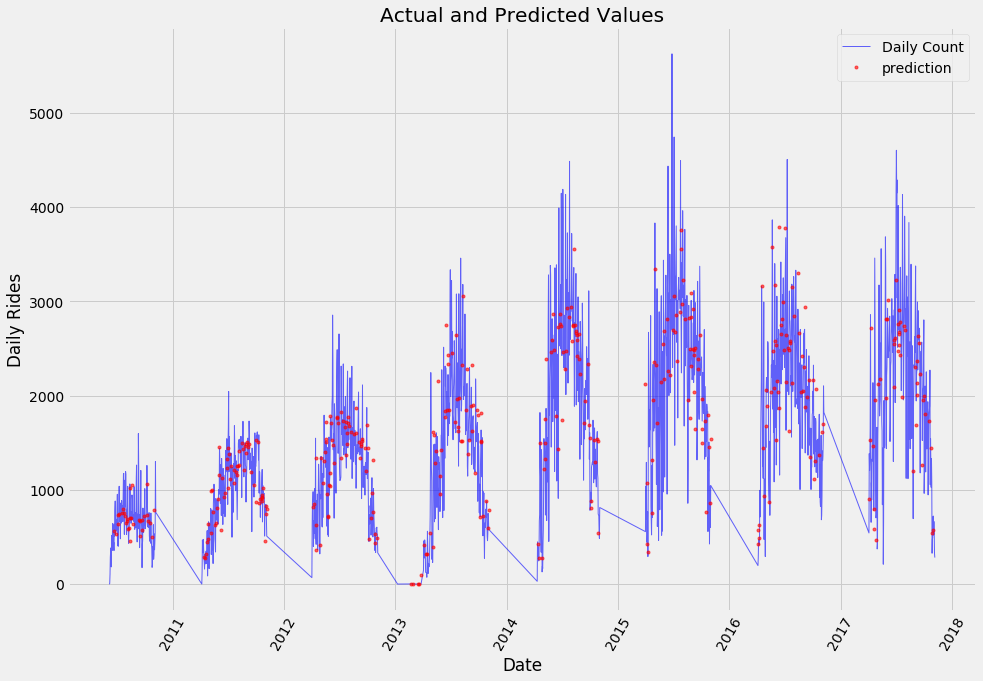

In [36]:
# Dates of training values
days = feat[:, feature_names.index('DAY')]
months = feat[:, feature_names.index('MONTH')]
years = feat[:, feature_names.index('YEAR')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'DCOUNT': target})

# Dates of predictions
months = X_test[:, feature_names.index('MONTH')]
days = X_test[:, feature_names.index('DAY')]
years = X_test[:, feature_names.index('YEAR')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['date'], true_data['DCOUNT'], 'b', label = 'Daily Count', linewidth=1, alpha=.6)

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Daily Rides'); plt.title('Actual and Predicted Values');

In [37]:
print(features.TMAX.values.shape)
print(target.shape)
print(X_test[:,5].shape)
print(predictions.shape)

(1667,)
(1667,)
(417,)
(417,)


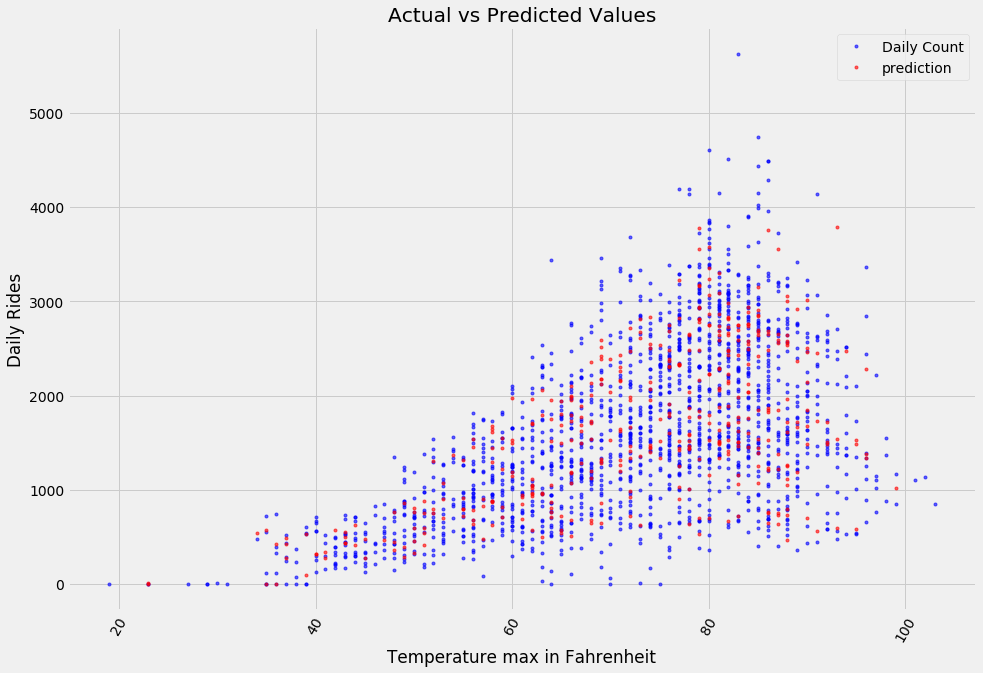

In [38]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'DCOUNT': target})

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,5], 'prediction': predictions})

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['DCOUNT'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');

## Testing

In [39]:
winter_features.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,DCOUNT,YEAR,MONTH,DAY,WEND
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.0,1255.000000,1255.000000,1255.000000,1255.000000
mean,9.165235,0.044861,0.275697,3.318725,27.729084,35.314741,19.905976,0.0,2013.329880,5.634263,15.676494,0.286853
std,3.740975,0.141718,1.033061,4.766686,16.218649,17.169311,16.053859,0.0,2.359857,4.553521,8.734551,0.452472
min,0.890000,0.000000,0.000000,0.000000,-17.000000,-12.000000,-23.000000,0.0,2010.000000,1.000000,1.000000,0.000000
25%,6.490000,0.000000,0.000000,0.000000,17.000000,24.000000,9.000000,0.0,2011.000000,2.000000,8.000000,0.000000
50%,8.720000,0.000000,0.000000,1.000000,28.000000,34.000000,20.000000,0.0,2013.000000,3.000000,16.000000,0.000000
75%,11.520000,0.010000,0.000000,5.000000,37.250000,45.000000,31.000000,0.0,2015.000000,11.000000,23.000000,1.000000
max,24.610000,1.730000,16.300000,24.000000,83.500000,95.000000,73.000000,0.0,2017.000000,12.000000,31.000000,1.000000


** What should be used for the DCOUNT data? **

In [40]:
winter_target = winter_features.DCOUNT.values

winter_feat = winter_features.drop('DCOUNT', axis=1).values
winter_names = list(winter_features.drop('DCOUNT', axis=1).columns)

In [41]:
# Splitting the data into training and test sets
wX, wX_test, wy, wy_test = train_test_split(winter_feat, winter_target, test_size=.25, random_state=42)

In [42]:
predictions = rf.predict(wX_test)

## Assessing the performance of our RandomForestRegressor

This is the r2 score

In [43]:
cv_score = cross_val_score(rf, wX, wy, cv=10)
print(cv_score)
print(np.mean(cv_score))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


In [44]:
errors = abs(predictions - wy_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  422.82


In [45]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / wy_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  -inf %


/home/grimoire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


## Playing with cross_val_score

In [46]:
'''
['class#accuracy', 'adjusted_mutual_info_score', 'clus#adjusted_rand_score', 'class#average_precision', 
'clus#completeness_score', 'explained_variance', 'class#f1', 'class#f1_macro', 'class#f1_micro', 'class#f1_samples', 
'class#f1_weighted', 'clus#fowlkes_mallows_score', 
'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 
'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 
'class#recall', 'class#recall_macro', 'class#recall_micro', 'class#recall_samples', 'class#recall_weighted', 
'class#roc_auc', 'clus#v_measure_score']
'''

"\n['class#accuracy', 'adjusted_mutual_info_score', 'clus#adjusted_rand_score', 'class#average_precision', \n'clus#completeness_score', 'explained_variance', 'class#f1', 'class#f1_macro', 'class#f1_micro', 'class#f1_samples', \n'class#f1_weighted', 'clus#fowlkes_mallows_score', \n'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', \n'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', \n'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', \n'class#recall', 'class#recall_macro', 'class#recall_micro', 'class#recall_samples', 'class#recall_weighted', \n'class#roc_auc', 'clus#v_measure_score']\n"